# LiDAR ICP Odometry

In [7]:
import os, sys, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from tqdm import tqdm
sys.path.append("/home/gurman_preet_526_gmail_com/lusnar_slam/src")
from lusnar_dataset import LuSNARDataset
plt.rcParams["figure.dpi"] = 120

In [8]:
DATA_ROOT = Path("/home/gurman_preet_526_gmail_com/lusnar_slam/datasets/Moon_1")
ds = LuSNARDataset(DATA_ROOT)
gt = ds.gt.astype(np.float64)
gt_xyz = gt[:, 1:4]
color_ts = ds.color_ts.astype(np.int64)
MAX_FRAMES = 600
N = min(MAX_FRAMES, len(color_ts), gt_xyz.shape[0])
color_ts = color_ts[:N]
t_gt = gt_xyz[:N]
print("Frames:", N)

[LuSNAR] Loaded 1094 frames.
Frames: 600


In [9]:
def se3_identity():
    return np.eye(4, dtype=np.float64)
def se3_mul(T1, T2):
    return T1 @ T2
def translation_rmse(pred, gt):
    diff = pred - gt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

In [10]:
class LiDAROdometry:
    def __init__(self, voxel_size=0.2):
        self.voxel_size = voxel_size
        self.prev_pcd = None
    def points_to_pcd(self, pts):
        pts3 = pts[:, :3]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts3)
        if self.voxel_size and self.voxel_size > 0:
            pcd = pcd.voxel_down_sample(self.voxel_size)
        pcd.estimate_normals(
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30)
        )
        return pcd
    def process(self, pts):
        pcd = self.points_to_pcd(pts)
        if self.prev_pcd is None:
            self.prev_pcd = pcd
            return se3_identity(), {"fitness": 1.0, "rmse": 0.0}
        init = np.eye(4, dtype=np.float64)
        reg = o3d.pipelines.registration.registration_icp(
            pcd,
            self.prev_pcd,
            max_correspondence_distance=0.5,
            init=init,
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane(),
            criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=30),
        )
        T = reg.transformation
        info = {"fitness": float(reg.fitness), "rmse": float(reg.inlier_rmse)}
        self.prev_pcd = pcd
        return T, info
lidar_odom = LiDAROdometry(voxel_size=0.2)
T_lidar_list = [se3_identity()]
t_lidar_list = []
fitness_list = []
rmse_list = []
for i in tqdm(range(N), desc="LiDAR ICP"):
    ts = int(color_ts[i])
    pts = ds.load_lidar(ts)
    dT, info = lidar_odom.process(pts)
    T_new = se3_mul(T_lidar_list[-1], dT)
    T_lidar_list.append(T_new)
    t_lidar_list.append(T_new[:3, 3])
    fitness_list.append(info.get("fitness", 0.0))
    rmse_list.append(info.get("rmse", 0.0))
t_lidar = np.stack(t_lidar_list, axis=0)
fitness_arr = np.array(fitness_list, dtype=np.float32)
rmse_arr = np.array(rmse_list, dtype=np.float32)
rmse_lidar, err_lidar = translation_rmse(t_lidar, t_gt)
print("LiDAR RMSE [m]:", rmse_lidar)

LiDAR ICP: 100%|██████████████████████████████| 600/600 [00:58<00:00, 10.21it/s]

LiDAR RMSE [m]: 8.72674526565049


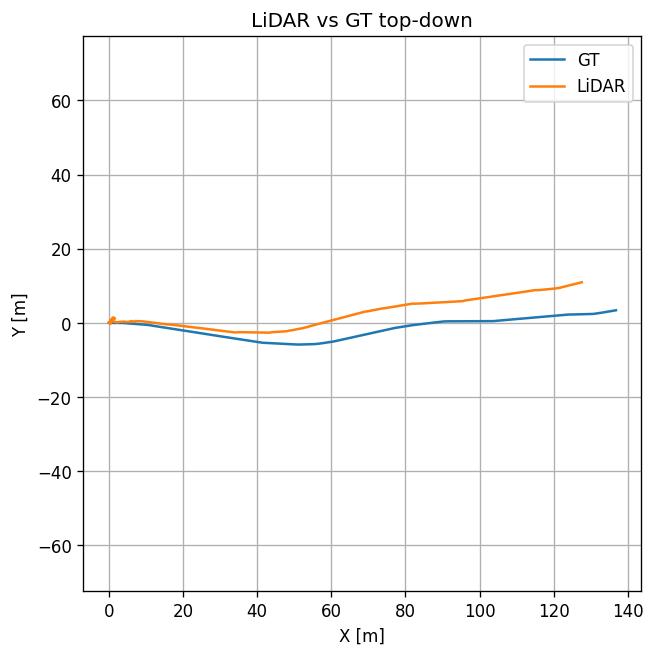

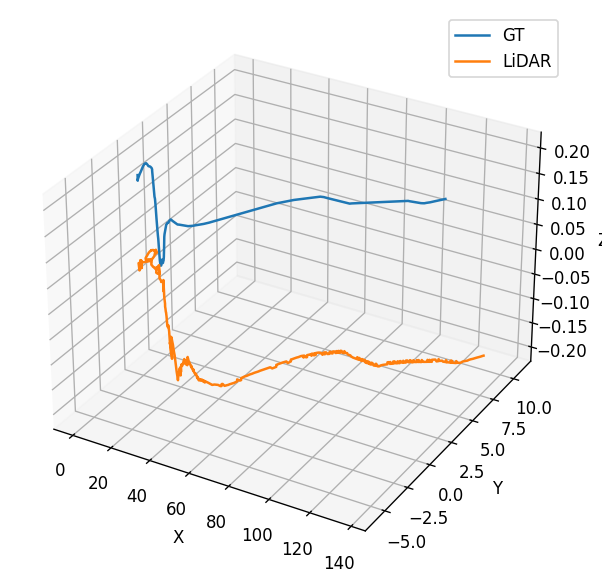

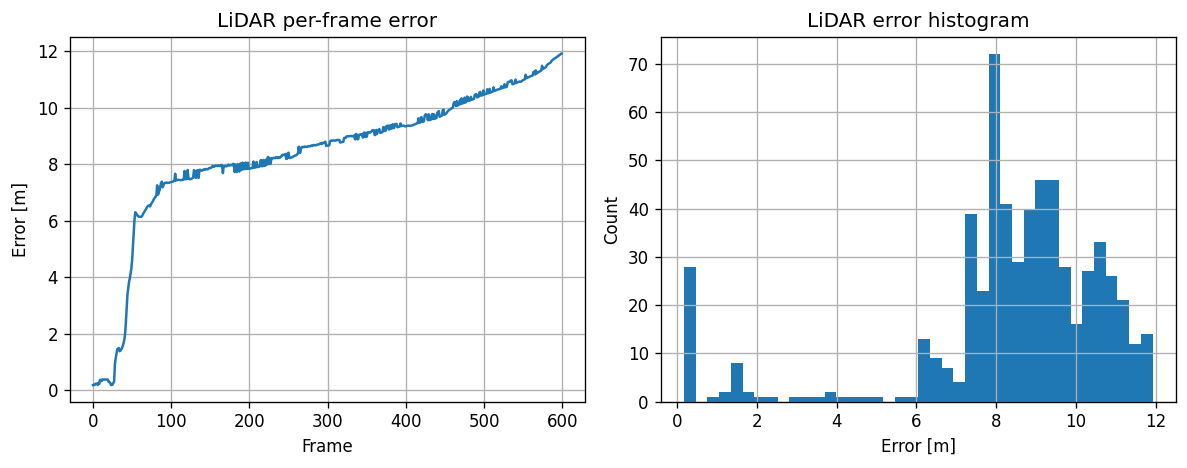

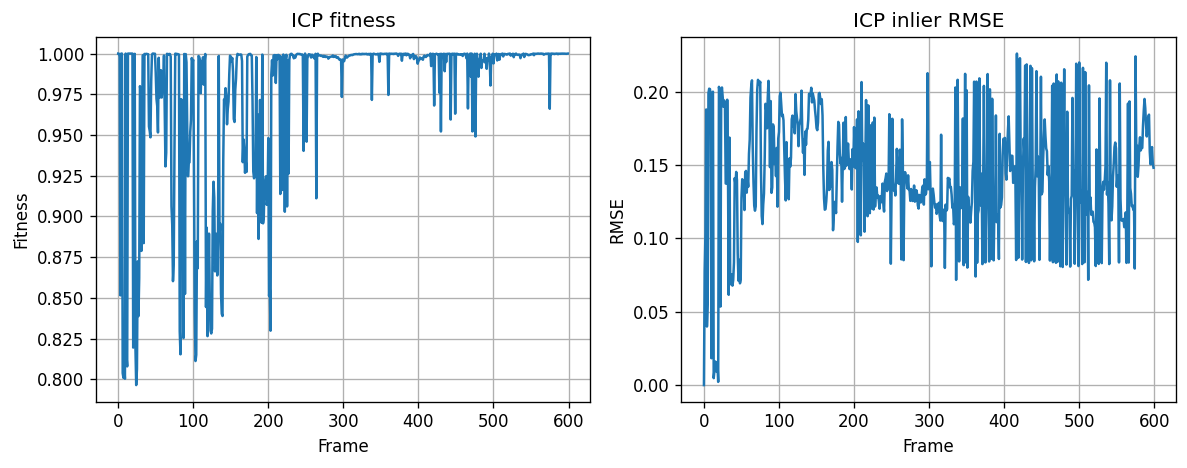

In [11]:
plt.figure(figsize=(6,6))
plt.plot(t_gt[:,0], t_gt[:,1], label="GT")
plt.plot(t_lidar[:,0], t_lidar[:,1], label="LiDAR")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("LiDAR vs GT top-down")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(t_gt[:,0], t_gt[:,1], t_gt[:,2], label="GT")
ax.plot(t_lidar[:,0], t_lidar[:,1], t_lidar[:,2], label="LiDAR")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
frames = np.arange(N)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(frames, err_lidar)
plt.xlabel("Frame")
plt.ylabel("Error [m]")
plt.title("LiDAR per-frame error")
plt.grid(True)
plt.subplot(1,2,2)
plt.hist(err_lidar, bins=40)
plt.xlabel("Error [m]")
plt.ylabel("Count")
plt.title("LiDAR error histogram")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fitness_arr)
plt.xlabel("Frame")
plt.ylabel("Fitness")
plt.title("ICP fitness")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(rmse_arr)
plt.xlabel("Frame")
plt.ylabel("RMSE")
plt.title("ICP inlier RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
out_dir = Path("/home/gurman_preet_526_gmail_com/lusnar_slam/results_icp")
out_dir.mkdir(parents=True, exist_ok=True)
np.save(out_dir / "t_gt.npy", t_gt)
np.save(out_dir / "t_lidar.npy", t_lidar)
np.save(out_dir / "err_lidar.npy", err_lidar)
np.save(out_dir / "fitness.npy", fitness_arr)
np.save(out_dir / "rmse_icp_points.npy", rmse_arr)
np.savez(out_dir / "metrics_icp.npz", rmse_lidar=rmse_lidar, N=N)
print("Saved to", out_dir)

Saved to /home/gurman_preet_526_gmail_com/lusnar_slam/results_icp
